In [13]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors

num_atom_feat = 34
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return [x == s for s in allowable_set]


def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == s for s in allowable_set]


def atom_features(atom,explicit_H=False,use_chirality=True):
    """Generate atom features including atom symbol(10),degree(7),formal charge,
    radical electrons,hybridization(6),aromatic(1),Chirality(3)
    """
    symbol = ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'other']  # 10-dim
    degree = [0, 1, 2, 3, 4, 5, 6]  # 7-dim
    hybridizationType = [Chem.rdchem.HybridizationType.SP,
                              Chem.rdchem.HybridizationType.SP2,
                              Chem.rdchem.HybridizationType.SP3,
                              Chem.rdchem.HybridizationType.SP3D,
                              Chem.rdchem.HybridizationType.SP3D2,
                              'other']   # 6-dim
    results = one_of_k_encoding_unk(atom.GetSymbol(),symbol) + \
                  one_of_k_encoding(atom.GetDegree(),degree) + \
                  [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
                  one_of_k_encoding_unk(atom.GetHybridization(), hybridizationType) + [atom.GetIsAromatic()]  # 10+7+2+6+1=26

    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
        results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(),
                                                      [0, 1, 2, 3, 4])   # 26+5=31
    if use_chirality:
        try:
            results = results + one_of_k_encoding_unk(
                    atom.GetProp('_CIPCode'),
                    ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
        except:
            results = results + [False, False] + [atom.HasProp('_ChiralityPossible')]  # 31+3 =34
    return results


def adjacent_matrix(mol):
    adjacency = Chem.GetAdjacencyMatrix(mol)
    return np.array(adjacency)


def mol_features(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except:
        raise RuntimeError("SMILES cannot been parsed!")
    mol = Chem.AddHs(mol)
    atom_feat = np.zeros((mol.GetNumAtoms(), num_atom_feat))
    for atom in mol.GetAtoms():
        atom_feat[atom.GetIdx(), :] = atom_features(atom)
    adj_matrix = adjacent_matrix(mol)
    return atom_feat, adj_matrix

def load_tensor(file_name, dtype):
    return dtype(file_name).to(device) 


In [14]:
from word2vec import seq_to_kmers, get_protein_embedding
from gensim.models import Word2Vec
import torch
import os

"""CPU or GPU"""
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('The code uses GPU...')
else:
    device = torch.device('cpu')
    print('The code uses CPU!!!')

compounds, adjacencies,proteins,interactions = [], [], [], []
compound = "C1=CC=C2C(=C1)C3=NNC4=CC=CC(=C43)C2=O"
atom_feature ,adj = mol_features(compound)
compounds.append(atom_feature)
adjacencies.append(adj)
adjacencies = np.array(adjacencies)
model = Word2Vec.load("word2vec_30.model")
sequence = "MSRSKRDNNFYSVEIGDSTFTVLKRYQNLKPIGSGAQGIVCAAYDAILERNVAIKKLSRPFQNQTHAKRAYRELVLMKCVNHKNIIGLLNVFTPQKSLEEFQDVYIVMELMDANLCQVIQMELDHERMSYLLYQMLCGIKHLHSAGIIHRDLKPSNIVVKSDCTLKILDFGLARTAGTSFMMTPYVVTRYYRAPEVILGMGYKENVDLWSVGCIMGEMVCHKILFPGRDYIDQWNKVIEQLGTPCPEFMKKLQPTVRTYVENRPKYAGYSFEKLFPDVLFPADSEHNKLKASQARDLLSKMLVIDASKRISVDEALQHPYINVWYDPSEAEAPPPKIPDKQLDEREHTIEEWKELIYKEVMDLEERTKNGVIRGQPSPLGAAVINGSQHPSSSSSVNDVSSMSTDPTLASDTDSSLEAAAGPLGCCR"
protein_embedding = get_protein_embedding(model, seq_to_kmers(sequence))
proteins.append(protein_embedding)
interactions.append(np.array([1.0]))

compounds = load_tensor(compounds, torch.FloatTensor)
adjacencies = load_tensor(adjacencies.astype(np.float32), torch.FloatTensor)
proteins = load_tensor(proteins, torch.FloatTensor)
interactions = load_tensor(interactions, torch.LongTensor)
protein_num = [len(sequence)]
mol = Chem.MolFromSmiles(compound)
atom_num = [mol.GetNumAtoms()]
dataset = (compounds, adjacencies, proteins, interactions,atom_num,protein_num)

The code uses CPU!!!


In [6]:
atom_num

[31]

In [22]:
device


device(type='cpu')

In [15]:
from model_c2_protein import *

""" create model ,trainer and tester """
protein_dim = 100
atom_dim = 34
hid_dim = 64
n_layers = 4
n_heads = 8
pf_dim = 256
dropout = 0.1
batch = 64
lr = 1e-4
weight_decay = 1e-4
decay_interval = 5
lr_decay = 1.0
iteration = 100
kernel_size = 9

encoder = Encoder(protein_dim, hid_dim, n_layers, kernel_size, dropout, device)
decoder = Decoder(atom_dim, hid_dim, n_layers, n_heads, pf_dim, DecoderLayer, SelfAttention, PositionwiseFeedforward, dropout, device)
model = Predictor(encoder, decoder, device)
model.load_state_dict(torch.load("lr=1e-4,dropout=0.1,weight_decay=1e-4,kernel=9,n_layer=4,batch=64,lookaheadradam,2",map_location = lambda storage,loc:storage))
model

Predictor(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (1): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (2): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (3): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (fc): Linear(in_features=100, out_features=64, bias=True)
    (gn): GroupNorm(8, 128, eps=1e-05, affine=True)
    (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Decoder(
    (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (sa): SelfAttention(
      (w_q): Linear(in_features=64, out_features=64, bias=True)
      (w_k): Linear(in_features=64, out_features=64, bias=True)
      (w_v): Linear(in_features=64, out_features=64, bias=True)
      (fc): Linear(in_features=64, out_features=64, bias=True)
      (do): Dropout(p=0.1, inplace=False)
    )
    (laye

In [33]:
with torch.no_grad():
    model.eval()
    predicted_scores,attention = model(dataset, train=False)
predicted_scores,attention

(array([0.87645805], dtype=float32),
 tensor([[[[1.1979e-03, 1.7476e-03, 6.5823e-04,  ..., 2.6190e-03,
            1.5309e-02, 3.0451e-03],
           [1.1979e-03, 1.7476e-03, 6.5823e-04,  ..., 2.6190e-03,
            1.5309e-02, 3.0451e-03],
           [1.1357e-03, 1.7746e-03, 6.1854e-04,  ..., 2.6887e-03,
            1.6399e-02, 3.0504e-03],
           ...,
           [9.3283e-04, 1.4592e-03, 5.5230e-04,  ..., 2.7380e-03,
            1.8181e-02, 3.9466e-03],
           [9.3283e-04, 1.4592e-03, 5.5230e-04,  ..., 2.7380e-03,
            1.8181e-02, 3.9466e-03],
           [9.3283e-04, 1.4592e-03, 5.5230e-04,  ..., 2.7380e-03,
            1.8181e-02, 3.9466e-03]],
 
          [[1.8071e-03, 9.5505e-05, 8.1233e-03,  ..., 1.2733e-05,
            9.7492e-04, 9.7067e-05],
           [1.8071e-03, 9.5505e-05, 8.1233e-03,  ..., 1.2733e-05,
            9.7492e-04, 9.7067e-05],
           [1.8297e-03, 9.6753e-05, 8.2493e-03,  ..., 1.4054e-05,
            9.5728e-04, 1.1073e-04],
           ...,
 

In [34]:
attention.shape

torch.Size([1, 8, 25, 425])

In [35]:
attention = attention.squeeze(0)

# attention = attention.numpy()
# # list = [11,16,1,21,4,17,9,22,12]
# sum = np.zeros(attention.shape[1])
# for i in list:
#     k = attention[i,:]
#     sum += k

sum = torch.sum(attention,dim=0)
sum = sum.numpy()
sum

array([[0.01493002, 0.00933837, 0.02607854, ..., 0.00541077, 0.02423104,
        0.01820267],
       [0.01493002, 0.00933837, 0.02607854, ..., 0.00541077, 0.02423104,
        0.01820267],
       [0.01458601, 0.00926499, 0.02613137, ..., 0.00548346, 0.02534992,
        0.01774161],
       ...,
       [0.01352427, 0.00878863, 0.02738293, ..., 0.00571844, 0.02713521,
        0.01851632],
       [0.01352427, 0.00878863, 0.02738293, ..., 0.00571844, 0.02713521,
        0.01851632],
       [0.01352426, 0.00878863, 0.02738293, ..., 0.00571844, 0.02713521,
        0.01851632]], dtype=float32)

In [40]:
sum = np.sum(sum,0)
sum.shape

(425,)

In [41]:
sum

array([0.35659012, 0.22110486, 0.6755632 , 0.20698023, 0.57944775,
       0.36527482, 0.14011627, 0.07320638, 0.59903175, 0.24134976,
       0.5631027 , 0.19514611, 0.28513914, 0.27401498, 0.5659255 ,
       0.2110916 , 0.37827536, 0.87671125, 0.17527753, 1.1612573 ,
       0.20086887, 0.44304007, 0.22248152, 0.2798514 , 0.62259424,
       0.35498646, 0.36688292, 0.6662818 , 0.45318633, 0.17901203,
       0.42448157, 0.18258658, 0.44494358, 0.38328946, 0.42309314,
       0.34661895, 0.6304838 , 0.5721212 , 0.28123122, 0.32441673,
       0.20327508, 0.42422366, 0.27652457, 1.0236802 , 0.5840236 ,
       0.14437503, 0.41046658, 0.43499845, 0.16767395, 0.22267812,
       0.58217347, 0.39069942, 0.24707559, 0.30052635, 0.22393672,
       0.39280194, 1.030517  , 0.21532841, 0.26381472, 0.4671945 ,
       0.14531422, 0.6175298 , 0.21127498, 0.6614977 , 0.8678934 ,
       0.22098257, 0.47614136, 0.57754844, 0.5472906 , 0.45240977,
       0.35651964, 0.47327766, 0.6013944 , 0.33102077, 0.21683

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [46]:
sum.mean()

0.47058824

Text(0.5, 1.0, 'MAPK8 attention weight distribution')

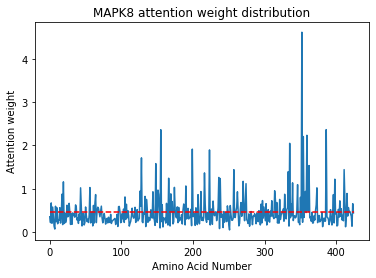

In [48]:
fig1 = plt.figure()
x = np.linspace(0, 425)
y = [0.471]*50
plt.plot(sum)
plt.xlabel("Amino Acid Number")
plt.ylabel("Attention weight")
plt.plot(x,y,"r--")
plt.title("MAPK8 attention weight distribution")

In [67]:
fig1.savefig("MAPK8 attention weight distribution.png",dpi=800)